In [4]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torchvision.models as model
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [5]:
df = pd.read_csv('/kaggle/input/cmi-detect-behavior-with-sensor-data/train.csv')
df.head()

,row_id,sequence_type,sequence_id,sequence_counter,subject,orientation,behavior,phase,gesture,acc_x,...,tof_5_v54,tof_5_v55,tof_5_v56,tof_5_v57,tof_5_v58,tof_5_v59,tof_5_v60,tof_5_v61,tof_5_v62,tof_5_v63
0,SEQ_000007_000000,Target,SEQ_000007,0,SUBJ_059520,Seated Lean Non Dom - FACE DOWN,Relaxes and moves hand to target location,Transition,Cheek - pinch skin,6.683594,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
1,SEQ_000007_000001,Target,SEQ_000007,1,SUBJ_059520,Seated Lean Non Dom - FACE DOWN,Relaxes and moves hand to target location,Transition,Cheek - pinch skin,6.949219,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
2,SEQ_000007_000002,Target,SEQ_000007,2,SUBJ_059520,Seated Lean Non Dom - FACE DOWN,Relaxes and moves hand to target location,Transition,Cheek - pinch skin,5.722656,...,-1.0,-1.0,112.0,119.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
3,SEQ_000007_000003,Target,SEQ_000007,3,SUBJ_059520,Seated Lean Non Dom - FACE DOWN,Relaxes and moves hand to target location,Transition,Cheek - pinch skin,6.601562,...,-1.0,-1.0,101.0,111.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
4,SEQ_000007_000004,Target,SEQ_000007,4,SUBJ_059520,Seated Lean Non Dom - FACE DOWN,Relaxes and moves hand to target location,Transition,Cheek - pinch skin,5.566406,...,-1.0,-1.0,101.0,109.0,125.0,-1.0,-1.0,-1.0,-1.0,-1.0


In [6]:
df = df.drop('row_id', axis=1)

In [7]:
print(df.columns)

Index(['sequence_type', 'sequence_id', 'sequence_counter', 'subject',
       'orientation', 'behavior', 'phase', 'gesture', 'acc_x', 'acc_y',
       ...
       'tof_5_v54', 'tof_5_v55', 'tof_5_v56', 'tof_5_v57', 'tof_5_v58',
       'tof_5_v59', 'tof_5_v60', 'tof_5_v61', 'tof_5_v62', 'tof_5_v63'],
      dtype='object', length=340)


700
29


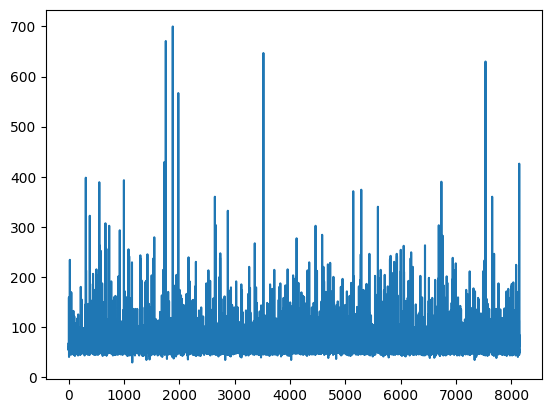

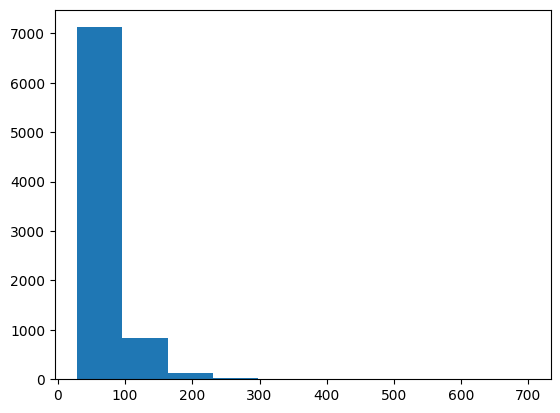

In [53]:
grouped_df = df.groupby('sequence_id')
i = 0

_lgd_list = []
for gd in grouped_df:
    lgd = list(gd)

    # print(lgd[0])

    # print(lgd[0], (lgd[1]))
    _lgd_list.append(len(lgd[1]))    

print(max(_lgd_list))
print(min(_lgd_list))

plt.plot(_lgd_list)
plt.show()

plt.hist(_lgd_list)
plt.show()

# d = list(grouped_df)
# print(d[0], d[1])
# print(len(d))

In [54]:
print(len(_lgd_list))

8151


# Handle Categorical data

In [10]:
obj_cols = [col for col in df.columns if df[col].dtype == 'object']
print(obj_cols)

['sequence_type', 'sequence_id', 'subject', 'orientation', 'behavior', 'phase', 'gesture']


In [11]:
from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()

reverse_sequence_type = []
reverse_gesture = []

for col in obj_cols:
    df[col] = encoder.fit_transform(df[col])
    if col == 'sequence_type':
        reverse_sequence_type = list(encoder.classes_)
    elif col == 'gesture':
        reverse_gesture = list(encoder.classes_)

print(df[obj_cols].head())

   sequence_type  sequence_id  subject  orientation  behavior  phase  gesture
0              1            0       73            2         3      1        1
1              1            0       73            2         3      1        1
2              1            0       73            2         3      1        1
3              1            0       73            2         3      1        1
4              1            0       73            2         3      1        1


In [12]:
print(reverse_sequence_type)
print(reverse_gesture)

['Non-Target', 'Target']
['Above ear - pull hair', 'Cheek - pinch skin', 'Drink from bottle/cup', 'Eyebrow - pull hair', 'Eyelash - pull hair', 'Feel around in tray and pull out an object', 'Forehead - pull hairline', 'Forehead - scratch', 'Glasses on/off', 'Neck - pinch skin', 'Neck - scratch', 'Pinch knee/leg skin', 'Pull air toward your face', 'Scratch knee/leg skin', 'Text on phone', 'Wave hello', 'Write name in air', 'Write name on leg']


# Filling Missing Values

In [13]:
df = df.ffill()
print(df.isna().sum())

sequence_type       0
sequence_id         0
sequence_counter    0
subject             0
orientation         0
                   ..
tof_5_v59           0
tof_5_v60           0
tof_5_v61           0
tof_5_v62           0
tof_5_v63           0
Length: 340, dtype: int64


In [40]:
class CMIDataset(Dataset):
    """
        Gives 2 things data and target.
        data contains all the columns except, sequence_type and gesture
        target contains sequence_type and gesture.

        sequence_type has 2 classes: Target (BFRB), Non-Target(Non BFRB)
        gesture
    """
    
    def __init__(self):
        super().__init__()

        self.data = df
        self.data = self.data.groupby('sequence_id')
        self.data = list(self.data)
        

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        d = self.data[idx]
        x = d[1].drop(['sequence_type', 'gesture'], axis=1).values
        y = d[1][['sequence_type', 'gesture']].values

        x = torch.from_numpy(x)
        y = torch.from_numpy(y)

        return x, y[0]

In [41]:
dataset = CMIDataset()

In [42]:
x, y = dataset[0]
print(x, x.shape)
print(y, y.shape)

tensor([[  0.,   0.,  73.,  ...,  -1.,  -1.,  -1.],
        [  0.,   1.,  73.,  ...,  -1.,  -1.,  -1.],
        [  0.,   2.,  73.,  ...,  -1.,  -1.,  -1.],
        ...,
        [  0.,  54.,  73.,  ..., 105.,  98.,  95.],
        [  0.,  55.,  73.,  ..., 102.,  96.,  94.],
        [  0.,  56.,  73.,  ...,  98.,  96.,  94.]], dtype=torch.float64) torch.Size([57, 338])
tensor([1, 1]) torch.Size([2])


In [43]:
from torch.nn.utils.rnn import pad_sequence

def collate_variable_length(batch):
    xs, ys = zip(*batch)  # list of tensors

    lengths = torch.tensor([x.shape[0] for x in xs])  # original sequence lengths
    padded_xs = pad_sequence(xs, batch_first=True)    # shape: [B, T_max, 338]
    ys = torch.stack(ys)                              # shape: [B, 2]

    return padded_xs, lengths, ys

In [44]:
batch_size=16
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_variable_length)

In [56]:
for d in dataloader:
    print(type(d))
    print(len(d))
    print(d[0])
    print(d[0].shape)
    print(d[1])
    print(d[1].shape)
    print(d[2])
    print(d[2].shape)
    break

<class 'tuple'>
3
tensor([[[ 7.6360e+03,  0.0000e+00,  7.5000e+01,  ...,  1.2500e+02,
           1.2300e+02,  1.2800e+02],
         [ 7.6360e+03,  1.0000e+00,  7.5000e+01,  ...,  1.2500e+02,
           1.2700e+02,  1.2100e+02],
         [ 7.6360e+03,  2.0000e+00,  7.5000e+01,  ...,  1.2500e+02,
           1.2100e+02,  1.2500e+02],
         ...,
         [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
           0.0000e+00,  0.0000e+00],
         [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
           0.0000e+00,  0.0000e+00],
         [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
           0.0000e+00,  0.0000e+00]],

        [[ 3.3100e+02,  0.0000e+00,  0.0000e+00,  ..., -1.0000e+00,
          -1.0000e+00, -1.0000e+00],
         [ 3.3100e+02,  1.0000e+00,  0.0000e+00,  ..., -1.0000e+00,
          -1.0000e+00, -1.0000e+00],
         [ 3.3100e+02,  2.0000e+00,  0.0000e+00,  ..., -1.0000e+00,
          -1.0000e+00, -1.0000e+00],
         ...,
       

As each data size is of different size. Thus creating a batched dataset (dataloader) will be difficult. 

### Date: July 2 2025
problem solved using padding.
How it works:
for a given batch, pads all the elements to the max length in that batch.

# Models

We will make our seperate models and train independently. If possible share the architecture.

In [17]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class SOTABinaryClassifier(nn.Module):
    def __init__(self, input_dim=338, hidden_dim=512, dropout=0.2, num_blocks=4):
        super(SOTABinaryClassifier, self).__init__()

        self.input_norm = nn.LayerNorm(input_dim)
        self.input_proj = nn.Linear(input_dim, hidden_dim)

        self.blocks = nn.Sequential(*[
            ResidualMLPBlock(hidden_dim, dropout)
            for _ in range(num_blocks)
        ])

        self.classifier = nn.Sequential(
            nn.LayerNorm(hidden_dim),
            nn.Linear(hidden_dim, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.input_norm(x)
        x = self.input_proj(x)
        x = self.blocks(x)
        return self.classifier(x)


class ResidualMLPBlock(nn.Module):
    def __init__(self, dim, dropout=0.2):
        super().__init__()
        self.norm1 = nn.LayerNorm(dim)
        self.ffn = nn.Sequential(
            nn.Linear(dim, dim * 2),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(dim * 2, dim),
            nn.Dropout(dropout)
        )

    def forward(self, x):
        return x + self.ffn(self.norm1(x))  # Residual connection

In [20]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [21]:
model = SOTABinaryClassifier(input_dim=338).to(device)
criterion = nn.BCELoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-4)

In [27]:
from tqdm import tqdm
epochs = 1

for epoch in tqdm(range(epochs)):
    model.train()
    cnt = 0
    for X_batch, y_batch in dataloader:
        X_batch = X_batch.to(device).float()
        y_batch = y_batch.to(device).float()
        
        optimizer.zero_grad()
        outputs = model(X_batch).squeeze()

        # print(outputs)
        loss = criterion(outputs, y_batch[:, 0].float())
        loss.backward()
        optimizer.step()


        print(cnt, loss)
        cnt += 1
    


  0%|          | 0/1 [00:00<?, ?it/s]

0 tensor(0.5377, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
1 tensor(0.6398, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
2 tensor(0.5638, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
3 tensor(0.5847, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
4 tensor(0.5530, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
5 tensor(0.6455, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
6 tensor(0.5490, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
7 tensor(0.6325, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
8 tensor(0.4482, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
9 tensor(0.5223, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
10 tensor(0.6793, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
11 tensor(0.6131, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
12 tensor(0.5622, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
13 tensor(0.5294, device='cuda:0', grad_fn=<Bina

  0%|          | 0/1 [02:30<?, ?it/s]

2784 tensor(0.4643, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
2785 tensor(0.5080, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)


KeyboardInterrupt: 